In [1]:
# Import packages
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("settlement.csv")

In [3]:
df.head()

,UniqueID,Date,Time of the Day,Day of week,Latitude,Longitude,Agg. Active RSCP (dBm),Agg. Active Ec/Io (dB),UE Received Power (RSSI - dBm): Top #1,Call Established,Settlement
0,132,2/18/2022,Morning,Friday,7.301352,5.151550,0.0,0.0,0.0,0,Urban
1,237,2/18/2022,Morning,Friday,7.286134,5.168570,-68.0,3.3,0.0,0,Rural
2,1167,2/18/2022,Morning,Friday,7.256312,5.220053,0.0,0.0,0.0,0,Sub-Urban
3,1380,2/18/2022,Morning,Friday,7.251329,5.205139,-67.0,0.0,0.0,0,Sub-Urban
4,1740,2/18/2022,Evening,Friday,7.263557,5.160170,0.0,0.0,0.0,1,Rural


In [4]:
df.dtypes

UniqueID                                    int64
Date                                       object
Time of the Day                            object
Day of week                                object
Latitude                                  float64
Longitude                                 float64
Agg. Active RSCP (dBm)                    float64
Agg. Active Ec/Io (dB)                    float64
UE Received Power (RSSI - dBm): Top #1    float64
Call Established                            int64
Settlement                                 object
dtype: object

In [5]:
df.drop(["UniqueID","Date"], axis = 1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Time of the Day                         170 non-null    object 
 1   Day of week                             170 non-null    object 
 2   Latitude                                170 non-null    float64
 3   Longitude                               170 non-null    float64
 4   Agg. Active RSCP (dBm)                  170 non-null    float64
 5   Agg. Active Ec/Io (dB)                  170 non-null    float64
 6   UE Received Power (RSSI - dBm): Top #1  170 non-null    float64
 7   Call Established                        170 non-null    int64  
 8   Settlement                              170 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 12.1+ KB


In [7]:
target = "Call Established"
y = df[target]
X = df.drop(["Call Established"], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (136, 8)
y_train shape: (136,)
X_test shape: (34, 8)
y_test shape: (34,)


In [9]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.93


In [10]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(n_estimators=100, max_depth=15)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Time of the Day', 'Day of week',
                                     'Settlement'],
                               use_cat_names=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=15))])

In [15]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.97
Test Accuracy: 1.0


# Upsampling

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [19]:
#smote = SMOTE()

In [22]:
#X_train_synth, y_train_synth = smote.fit_resample(X_train, y_train)

In [21]:
X_train.head()

,Time of the Day,Day of week,Latitude,Longitude,Agg. Active RSCP (dBm),Agg. Active Ec/Io (dB),UE Received Power (RSSI - dBm): Top #1,Settlement
69,Morning,Thursday,7.302845,5.141240,-75.000000,0.0,0.000000,Urban
138,Evening,Tuesday,7.281401,5.190765,-74.599998,-13.6,-60.599998,Rural
2,Morning,Friday,7.256312,5.220053,0.000000,0.0,0.000000,Sub-Urban
93,Evening,Friday,7.251216,5.193949,-68.400002,-14.0,-53.799999,Sub-Urban
136,Morning,Tuesday,7.305357,5.143816,-67.000000,-12.8,-54.500000,Urban


Since we dealing with imbalance data, we upsample the training data to balance the amount of call esctablished and call dropped and then fit it to the model.

In [26]:
def balance_sample(x_train, y_train, sample_mode='up'):
    train_df = x_train.copy()
    train_df['Call Establishment'] = y_train

    train_minority = train_df[train_df['Call Establishment'] == 0]
    train_majority = train_df[train_df['Call Establishment'] == 1]

    train_sampled_df = pd.DataFrame()

    if sample_mode == 'down':
        train_majority_down = resample(train_majority, replace=False,  n_samples=train_minority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_minority, train_majority_down])  
    else:
        train_minority_up = resample(train_minority, replace=True,  n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority, train_minority_up])

    x_train_samp = train_sampled_df.drop(['Call Establishment'], axis=1)
    y_train_samp = train_sampled_df['Call Establishment']

    return x_train_samp, y_train_samp 

In [39]:
#upsample random forest
X_train_up, y_train_up = balance_sample(X_train, y_train, sample_mode='up')

print(y_train_up.value_counts())
print(y_train_up.value_counts(normalize=True))

1    126
0    126
Name: Call Establishment, dtype: int64
1    0.5
0    0.5
Name: Call Establishment, dtype: float64


In [40]:
model.fit(X_train_up,y_train_up)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Time of the Day', 'Day of week',
                                     'Settlement'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [41]:
acc_train_up = accuracy_score(y_train_up, model.predict(X_train_up))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train_up, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.98
Test Accuracy: 0.97


# Communication

In [42]:
from joblib import dump, load

In [43]:
dump(model, "callestablishment.joblib")

['callestablishment.joblib']

In [44]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[5.70473454e-01 4.29526546e-01]
 [7.85324261e-09 9.99999992e-01]
 [9.71854495e-01 2.81455049e-02]
 [1.17778278e-04 9.99882222e-01]
 [1.19843447e-07 9.99999880e-01]]


Extract the feature names and importances from your model

In [46]:
features = model.named_steps["onehotencoder"].get_feature_names_out()
importances = model.named_steps["logisticregression"].coef_[0]

In [47]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

Day of week_Friday                        0.030634
Day of week_Sunday                        0.536956
UE Received Power (RSSI - dBm): Top #1    0.583696
Day of week_Wednesday                     0.623767
Settlement_Sub-Urban                      0.726960
dtype: float64

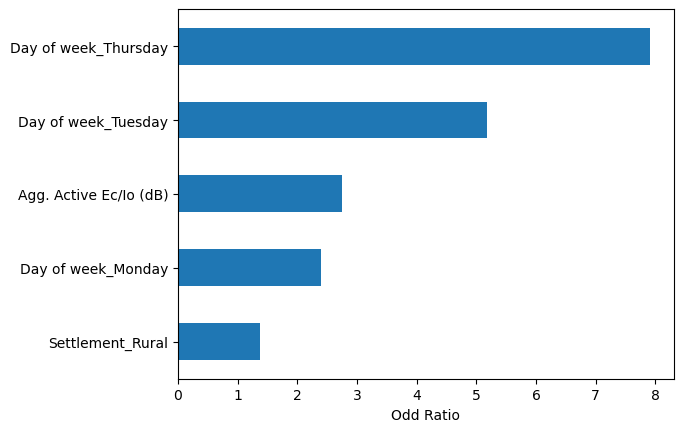

In [50]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odd Ratio");

We will Create a function "make_prediction" that takes four arguments certain inpute and returns predictions for an Call drop.

In [79]:
def make_prediction(TimeD,DayOfWeek, lat, lon, RSCP, EcIo, RSSI, settlement):
    data = {
        "Time of the Day": TimeD, #Time of the day either Morning/Evening
        "Day of week":DayOfWeek, # Day of the week either Monday/Tuesday/.../Sunday
        "Latitude": lat,
        "Longitude": lon,
        "Agg. Active RSCP (dBm)": RSCP,
        "Agg. Active Ec/Io (dB)":EcIo,
        "UE Received Power (RSSI - dBm): Top #1":RSSI,
        "Settlement": settlement
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    if prediction == 1:
        output_msg = "Call Etablished"
    else:
        output_msg = "Call Dropped"
    return output_msg

In [80]:
X_train.columns

Index(['Time of the Day', 'Day of week', 'Latitude', 'Longitude',
       'Agg. Active RSCP (dBm)', 'Agg. Active Ec/Io (dB)',
       'UE Received Power (RSSI - dBm): Top #1', 'Settlement'],
      dtype='object')

In [82]:
make_prediction("evening","Friday",7.256312,5.190765,-72,-12,-55,"Rural")

'Call Etablished'